# Tâche 3 - Classification automatique de produits alimentaires

Cette tâche vise à classifier de courts textes décrivant des produits alimentaires de la base de données *Open Food Facts Canada*.

Pour chaque produit, on retrouve son nom, ses catégories, ses ingrédients et ses informations nutritionnelles. Bien que les descriptions soient semi-structurées, on vous demande de les traiter comme des textes.

Une étiquette accompagne chaque produit. Elle correspond à son score NOVA, un indicateur du degré de transformation d'un aliment.  

Les objectifs de cette tâche sont:
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des probabilité ou poids d'attributs.

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement (validation croisée avec 5 partitions)et des données de test. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1).

Pour la deuxième partie, on vous demande d'étudier plus en détail chacune des classes NOVA. Faites une analyse des probabilités (ou poids) du modèle le plus performant pour identifier les attributs les plus importants de chacune des classes. Vous pouvez vous inspirer des *notebooks* disponibles sur le site du cours. Faites une analyse et présentez clairement vos conclusions. L’important ici est de dégager le thème principal à partir de vos observations et non pas de trouver la formulation exacte du score NOVA. Veuillez noter que certaines classes pourraient être difficiles à interpréter.

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_product_dataset*.

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_product_dataset* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section.

In [1]:
import json

train_json_fn = "./data/t3_produits_train.json"
test_json_fn = "./data/t3_produits_test.json"


def load_product_dataset(filename):
    with open(filename, 'r', encoding='utf-8') as fp:
        product_list = json.load(fp)
    return product_list

In [2]:
train_list = load_product_dataset(train_json_fn)
print("Nombre de produits:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre de produits: 8502

Un exemple:
 {'text': 'Name: Lait Partiellement écrémé 2 m.g., Categories: dairies, milks-liquid-and-powder, milks, semi-skimmed-milks, Ingredients: lait partiellement écrémé, palmitate de vitamine a vitamine ds, Nutrition: Carbohydrates: 5.2 g, Energy: 52 kcal, Fat: 2 g, Proteins: 3.6 g, Saturated Fat: 1.2 g, Sodium: 0.0 g, Sugars: 5.2 g', 'label': 'Groupe 1'}


In [3]:
test_list = load_product_dataset(test_json_fn)
print("Nombre de produits", len(test_list))
incident = test_list[10]
print("\nUne description de produit:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre de produits 2126

Une description de produit: Name: Sour Cherries, Categories: snacks, sweet-snacks, confectioneries, candies, Ingredients: sugars sugar, dextrose, corn syrup, maltodextrin , corn starch, modified corn starch, malic acid, acacia gum, citric acid, shellac, natural artificial flavours, carnauba wax, beeswax, allura red, Nutrition: Carbohydrates: 95 g, Energy: 375 kcal, Fat: 0 g, Proteins: 0 g, Saturated Fat: 0 g, Sodium: 0 g, Sugars: 82.5 g

Son étiquette: Groupe 4


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement de vos modèles. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au notebook si nécessaire.

In [4]:
!pip install scikit-learn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


In [5]:
def prepare_data(product_list):
    """
    Transforme une liste de produits en textes (texts) et étiquettes (labels).
    """
    texts = [product["text"] for product in product_list]
    labels = [product["label"] for product in product_list]
    return texts, labels

In [6]:
!pip install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def display_confusion_matrix(confusion_matrix, classes):
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.ylabel('Vrai étiquette ')
    plt.xlabel('Étiquette prédite')
    plt.title('Matrice de confusion')

In [7]:
from sklearn.metrics import  precision_score, recall_score, f1_score

def train_and_test_classifier(train_fn, test_fn, model='NB'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :return: un dictionnaire contenant au minimum 5 3 valeurs:
                 - l'accuracy à l'entraînement (validation croisée)
                 - l'accuracy sur le jeu de test
                 - la matrice de confusion calculée par scikit-learn sur les données de test
                 - le vectorizer construit dans cette fonction
                 - le modèle entraîné dans cette fonction
    """

    # Charger les données
    train_list = load_product_dataset(train_fn)
    test_list = load_product_dataset(test_fn)
    X_train, y_train = prepare_data(train_list)
    X_test, y_test = prepare_data(test_list)

    # Vectorisation (sac de mots)
    vectorizer = CountVectorizer(lowercase=True)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Choix du modèle
    if model == 'NB':
        clf = MultinomialNB()
    elif model == 'LR':
        clf = LogisticRegression(max_iter=1000)

    # Validation croisée (5 folds)
    scores = cross_val_score(clf, X_train_vec, y_train, cv=5, scoring='accuracy')
    accuracy_train = np.mean(scores)

    # Entraînement final sur tout le train
    clf.fit(X_train_vec, y_train)

    # Prédiction sur le test
    y_pred = clf.predict(X_test_vec)
    accuracy_test = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Calcul des métriques supplémentaires
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    display_confusion_matrix(cm, classes=clf.classes_)

    # Les résultats à retourner - remplacer les valeurs par vos résultats
    results = dict()
    results['accuracy_train'] = accuracy_train
    results['accuracy_test'] = accuracy_test
    results['confusion_matrix'] = cm
    results['vectorizer'] = vectorizer
    results['classifier'] = clf
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    return results



{'accuracy_train': np.float64(0.8693253795345299),
 'accuracy_test': 0.8706491063029163,
 'confusion_matrix': array([[ 184,    0,   30,    9],
        [   4,  177,    5,    8],
        [  20,    1,  263,   71],
        [  23,    3,  101, 1227]]),
 'vectorizer': CountVectorizer(),
 'classifier': MultinomialNB(),
 'precision': np.float64(0.8771063126118547),
 'recall': np.float64(0.8706491063029163),
 'f1_score': np.float64(0.8732245607273798)}

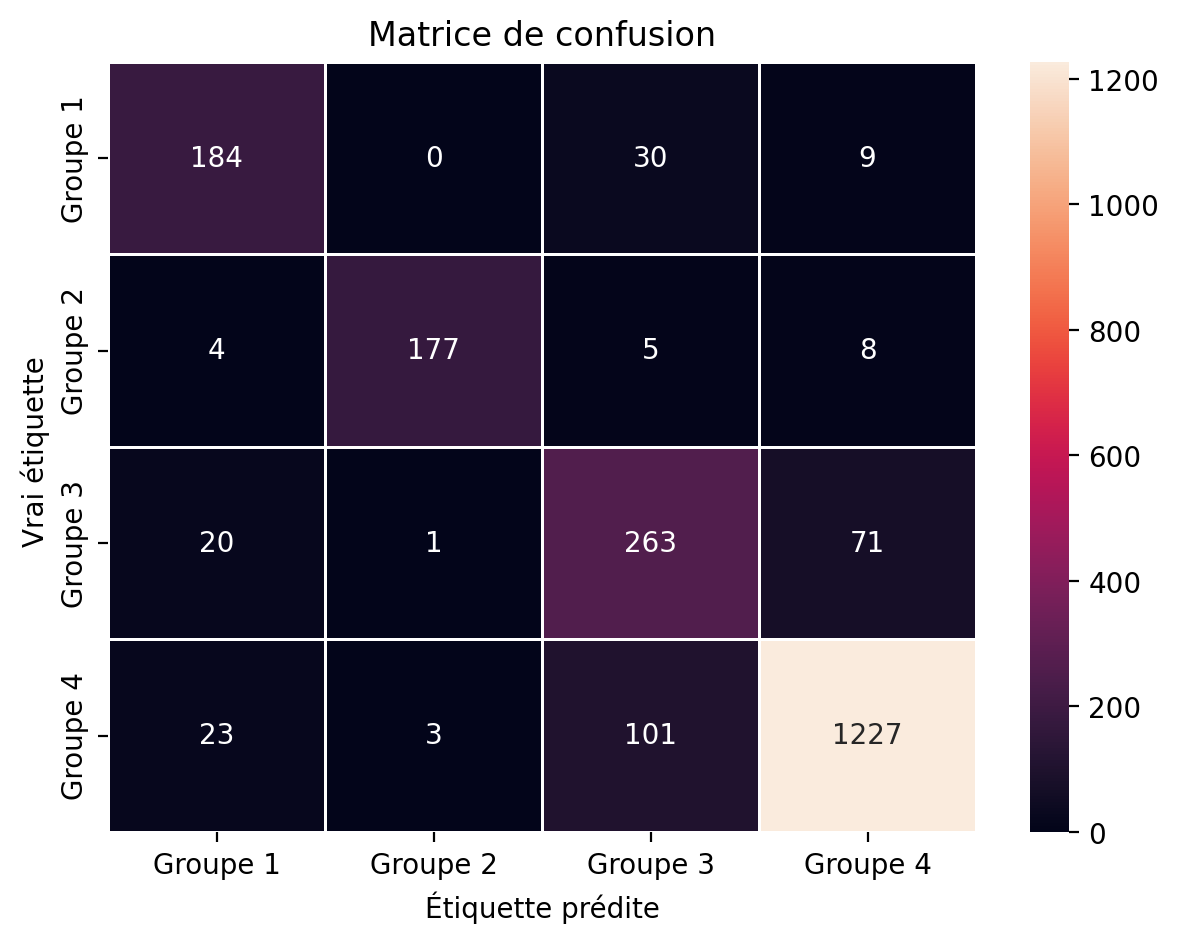

In [8]:
nb_results = train_and_test_classifier(train_json_fn, test_json_fn, model='NB')
nb_results

{'accuracy_train': np.float64(0.9271936231282638),
 'accuracy_test': 0.9379115710253998,
 'confusion_matrix': array([[ 210,    0,    6,    7],
        [   3,  187,    3,    1],
        [  13,    0,  314,   28],
        [  15,    1,   55, 1283]]),
 'vectorizer': CountVectorizer(),
 'classifier': LogisticRegression(max_iter=1000),
 'precision': np.float64(0.9403679908534187),
 'recall': np.float64(0.9379115710253998),
 'f1_score': np.float64(0.9387288038544287)}

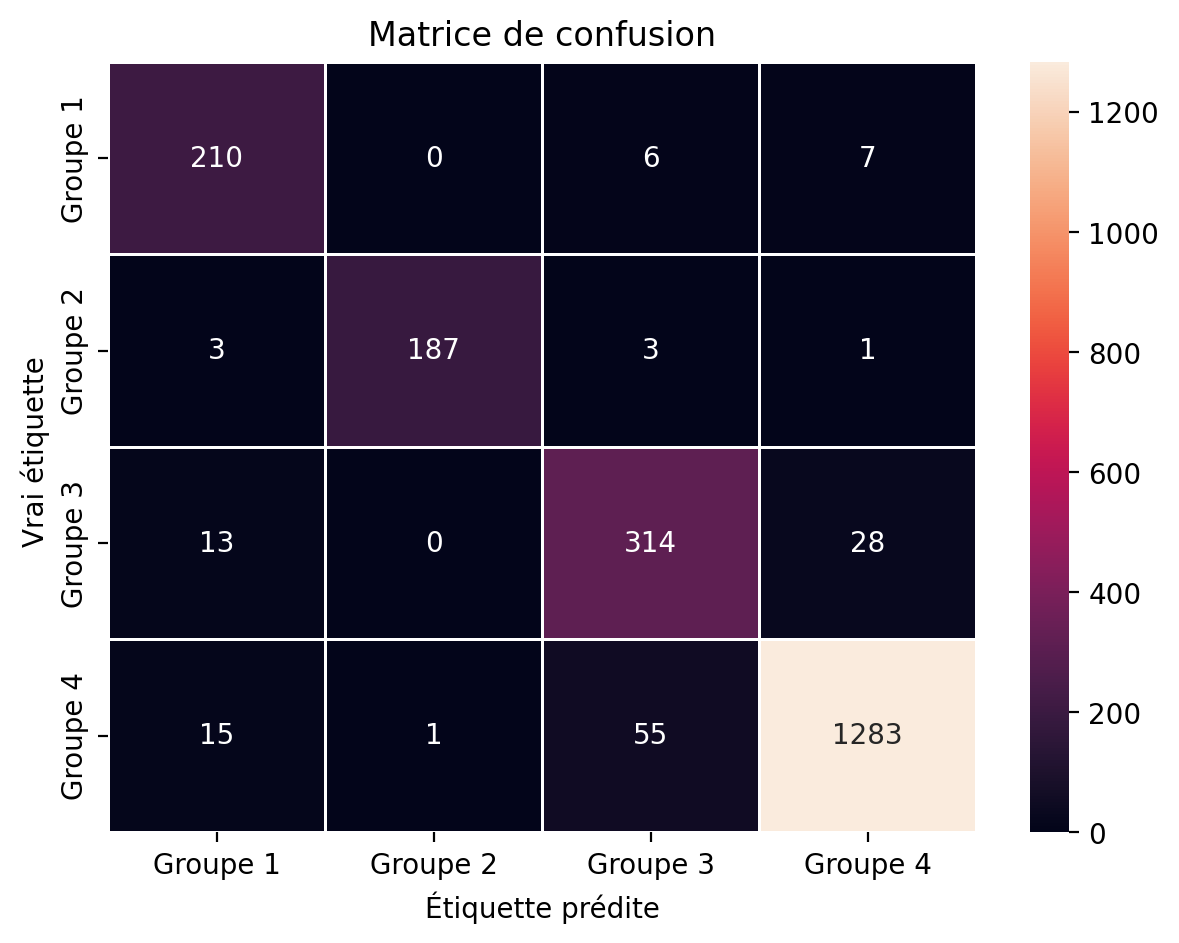

In [9]:
lr_results = train_and_test_classifier(train_json_fn, test_json_fn, model='LR')
lr_results

In [10]:
# Détermination du meilleur modèle
if nb_results['accuracy_test'] > lr_results['accuracy_test']:
    best_model = "Naive Bayes"
    best_results = nb_results
    diff = nb_results['accuracy_test'] - lr_results['accuracy_test']
else:
    best_model = "Régression Logistique"
    best_results = lr_results
    diff = lr_results['accuracy_test'] - nb_results['accuracy_test']

print(f"\n- MODÈLE RECOMMANDÉ: {best_model}")
print(f"Avantage en accuracy: +{diff:.4f}")

# Analyse du surapprentissage
nb_overfit = nb_results['accuracy_train'] - nb_results['accuracy_test']
lr_overfit = lr_results['accuracy_train'] - lr_results['accuracy_test']

print(f"\n- Analyse du surapprentissage:")
print(f"Naive Bayes: {nb_overfit:.4f}")
print(f"Régression Logistique: {lr_overfit:.4f}")

if abs(nb_overfit) < abs(lr_overfit):
    print("→ Naive Bayes montre moins de signes de surapprentissage")
else:
    print("→ Régression Logistique montre moins de signes de surapprentissage")


- MODÈLE RECOMMANDÉ: Régression Logistique
Avantage en accuracy: +0.0673

- Analyse du surapprentissage:
Naive Bayes: -0.0013
Régression Logistique: -0.0107
→ Naive Bayes montre moins de signes de surapprentissage


## Analyse des matrices de confusion

### Lecture générale
- **Lignes** = vraies classes (réalité).  
- **Colonnes** = prédictions du modèle.  
- La **diagonale** = bonnes prédictions.  
- Les **hors-diagonales** = erreurs (quelle classe a été confondue avec laquelle).  
- Groupe 1, 2, 3, 4 = NOVA 1, 2, 3, 4

---
On calcule le rappel pour les 2 modèles puisque cela mesure la capacité à bien capturer chaque classe.
On fait cela pour vérifier sur quelle groupe les modèles se trompent le plus.
On aurait pu aussi utiliser la précision et le F1-score.

### Résultats du modèle **Naïve Bayes (NB)**
- **NOVA1** : 182/223 = **81.6 %** correctement reconnus  
  → Erreurs principales : NOVA3 (**14.4 %**), NOVA4 (**4.0 %**)  
- **NOVA2** : 177/194 = **91.2 %**  
  → Erreurs principales : NOVA4 (**4.1 %**), NOVA3 (**3.1 %**)  
- **NOVA3** : 312/355 = **73.5 %**  
  → Erreur majeure : NOVA4 (**21.1 %**), NOVA1 (**5.1 %**)  
- **NOVA4** : 1223/1354 = **90.3 %**  
  → Erreur principale : NOVA3 (**7.6 %**), NOVA1 (**1.8 %**)  

**Conclusion partielle :**  
NOVA3 et NOVA4 se confondent le plus (dans les deux sens).


### Résultats du modèle **Régression Logistique (LR)**
- **NOVA1** : 209/223 = **93.7 %** correctement reconnus  
  → Erreurs principales : NOVA3 (**3.6 %**), NOVA4 (**2.7 %**)  
- **NOVA2** : 187/194 = **96.4 %**  
  → Erreurs principales : NOVA1 (**2.1 %**), NOVA3 (**1.5 %**)  
- **NOVA3** : 312/355 = **87.9 %**  
  → Erreur majeure : NOVA4 (**8.2 %**), NOVA1 (**3.9 %**)  
- **NOVA4** : 1285/1354 = **94.9 %**  
  → Erreur principale : NOVA3 (**4.0 %**), NOVA1 (**1.0 %**)  

**Conclusion partielle :**  
Ici aussi, NOVA3 et NOVA4 se confondent le plus, mais les erreurs sont **nettement réduites** par rapport à Naïve Bayes.  

---

## Comparaison des modèles

### Naïve Bayes (MultinomialNB)
- **Accuracy entraînement (CV 5 folds) :** 0.87  
- **Accuracy test :** 0.87  
- **Precision :** 0.877
- **Rappel :** 0.87
- **F1-score :** 0.873
- Points faibles : forte confusion entre **NOVA3** et **NOVA4**.  
- Avantages : rapide, simple, mais limité par l’hypothèse d’indépendance des mots.  

### Régression Logistique
- **Accuracy entraînement (CV 5 folds) :** 0.93  
- **Accuracy test :** 0.94  
- **Precision :** 0.94
- **Rappel :** 0.938
- **F1-score :** 0.939
- Points forts : meilleure précision globale, confusions réduites, pondération fine des termes discriminants.  
- Atouts : robuste, interprétable via les poids des coefficients.  

---

## Conclusion générale
- Les deux modèles confondent surtout **NOVA3** et **NOVA4**.  
- **La régression logistique est le modèle recommandé** :  
  - meilleures performances globales,  
  - moins de confusions,  
  - et meilleure explicabilité.  


## Section 3 - À quoi correspondent les classes? Explicabilité du meilleur modèle

En utilisant les probabilités ou les poids du modèle ayant obtenu la meilleure évaluation, tentez d'attribuer une signification à chacune des classes en identifiant leurs attributs les plus importants. Comme c'est une épreuve d'analyse de données, il est possible que certaines classes ne soient pas facilement interprétables. Vous n'êtes pas tenu à l'impossible. L'important est d'utiliser ce qu'on observe pour fournir une explication.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

In [11]:
def top_features_per_class(vectorizer, classifier, n):
    """
    Retourne les n mots les plus discriminants par classe.
    """
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = classifier.coef_
    top_words = {}

    for i, class_label in enumerate(classifier.classes_):
        # indices des plus grands coefficients
        top_idx = np.argsort(coefs[i])[-n:]
        top_features = feature_names[top_idx]
        top_weights = coefs[i][top_idx]
        top_words[class_label] = list(zip(top_features, top_weights))
    return top_words



Classe Groupe 1 :
  seeds (0.429)
  cut (0.433)
  peas (0.434)
  proteins (0.436)
  pastas (0.436)
  bicarbonate (0.443)
  palmitate (0.443)
  59 (0.446)
  white (0.450)
  mint (0.454)
  skyr (0.457)
  semi (0.471)
  no (0.475)
  pois (0.475)
  broths (0.481)
  boissons (0.484)
  dessert (0.489)
  d3 (0.491)
  copper (0.492)
  egg (0.492)
  fcf (0.496)
  all (0.497)
  mil (0.497)
  chlorophyllin (0.498)
  isomaltooligosaccharides (0.498)
  sulphite (0.514)
  graines (0.514)
  carotte (0.519)
  disodium (0.553)
  soya (0.553)
  chip (0.557)
  oikos (0.601)
  based (0.639)
  frozen (0.654)
  dijon (0.654)
  butter (0.659)
  levure (0.669)
  actives (0.670)
  added (0.686)
  sans (0.703)
  poulet (0.709)
  high (0.725)
  ingredients (0.743)
  yolk (0.762)
  66 (0.765)
  mix (0.796)
  chiches (0.852)
  dairy (0.852)
  bouillon (0.859)
  waters (1.305)

Classe Groupe 2 :
  600 (0.355)
  1130 (0.356)
  selected (0.360)
  specially (0.360)
  categories (0.370)
  cider (0.374)
  100 (0.374)
 

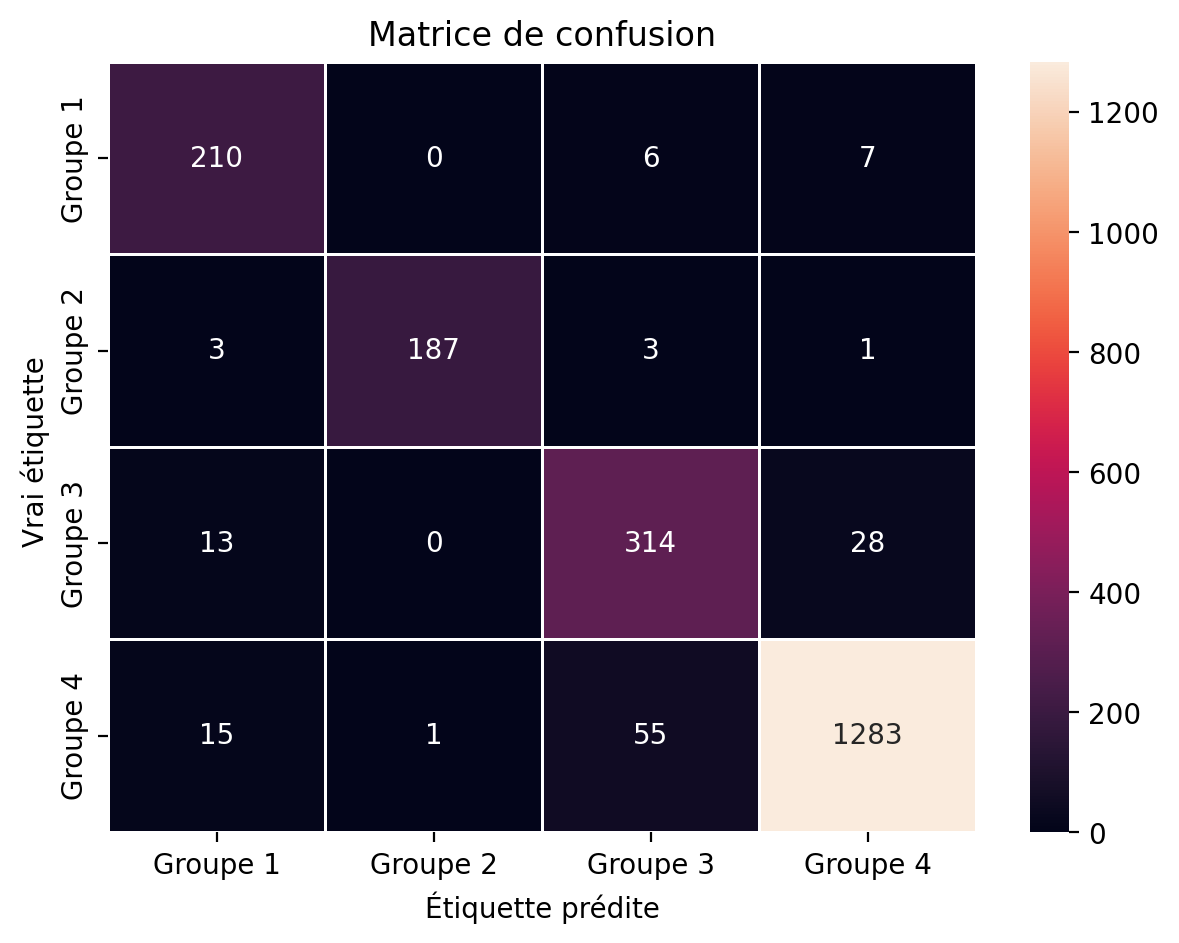

In [12]:
results_lr = train_and_test_classifier(train_json_fn, test_json_fn, model='LR') # On utilise la régression logistique puisque c'est le meilleur modèle
important_words = top_features_per_class(results_lr['vectorizer'],
                                         results_lr['classifier'], n=50)

for label, words in important_words.items():
    print(f"\nClasse {label} :")
    for w, score in words:
        print(f"  {w} ({score:.3f})")

## Analyse

### Classe 1 (NOVA 1 : aliments bruts ou peu transformés)

**Mots clés :** *butter, yolk, dairy, chiches (pois chiches), waters*  

On retrouve des termes directement liés à des ingrédients simples et naturels : produits laitiers, œufs, légumineuses, eau.  
On peut quand même retrouver le mot *66* avec un poids important car le modèle l’a repéré comme corrélé statistiquement à la classe 1 dans le corpus, mais il s’agit d’un artefact lié à la présence de nombres (dans "Name : Farfalle n 66" ou dans la composition de l'aliment) dans les textes et non d’un vrai indicateur alimentaire.

La présence de *butter*, *yolk* ou *dairy* montre que le modèle associe cette classe aux produits peu transformés, consommés tels quels ou après une transformation minimale (ex. pasteurisation, surgélation).  
**Profil :** aliments de base, bruts, peu ou pas transformés.  


### Classe 2 (NOVA 2 : ingrédients culinaires transformés)

**Mots clés :** *honey, coco, sugars, syrups, vinegars, salts, fats*  

On observe des ingrédients culinaires de transformation : sucre, miel, sirops, vinaigre, sel, graisses.  

Ce sont des produits utilisés pour cuisiner, mais rarement consommés seuls.  

Exemple typique : sucre de table, huile, sel de mer, sirop d’érable.  
**Profil :** ingrédients culinaires isolés, obtenus par pressage, raffinage ou extraction.  


### Classe 3 (NOVA 3 : aliments transformés)

**Mots clés :** *beers, érable, coriandre, couscous, lactose, betterave, sel*  

Mélange d’aliments où une transformation simple est réalisée : pain, bière, fromages, conserves, plats préparés simples.  

La présence de *beers* ou *érable* (produits fermentés ou transformés traditionnels) illustre bien cette catégorie.  

Les termes *sel* et *lactose* rappellent l’ajout d’ingrédients pour modifier le goût ou la conservation.  
**Profil :** aliments transformés traditionnels, souvent composés de quelques ingrédients reconnaissables.  


### Classe 4 (NOVA 4 : aliments ultra-transformés)

**Mots clés :** *lipase, flavor, gum, lécithine, arôme, annatto, glucose, dextrose, flavour, lecithin*  

Cette classe regroupe les mots liés aux additifs alimentaires : enzymes (*lipase*), gommes, arômes, colorants (*annatto*), édulcorants/sucres raffinés (*glucose, dextrose*).  

Présence forte d’émulsifiants et stabilisants (*lécithine, gum*).  

Les mots *flavour*, *arôme* soulignent la dimension artificielle des formulations.  
**Profil :** aliments ultra-transformés, riches en additifs, où la matrice alimentaire originale est fortement modifiée.  


## Conclusion

- **NOVA1** → produits simples et naturels (œufs, lait, pois chiches, eau).  
- **NOVA2** → ingrédients de base de la cuisine (miel, sucre, sel, graisses).  
- **NOVA3** → aliments transformés “traditionnels” (bières, couscous, produits fermentés, avec ajout de sel ou sucre).  
- **NOVA4** → produits industriels complexes (additifs, arômes, émulsifiants, sucres raffinés).  

Le modèle capte bien la **logique du score NOVA** :  
plus on monte en classe, plus les mots reflètent une **complexité artificielle** et une **industrialisation des procédés**.

---

## Ambiguïtés dans les mots discriminants

### 1. Le cas des *fraises*
À première vue, *fraise(s)* devrait apparaître en **NOVA 1** (fruit brut).  
Cependant, dans notre corpus, le mot n’apparaît que très rarement pour désigner le fruit frais.  
On le retrouve surtout dans des produits **transformés** : *yaourt aux fraises*, *jus de fraises*, *biscuits goût fraise*, *arôme de fraise*, *confiture de fraises*.  

Le modèle apprend donc que *fraise(s)* est statistiquement associé aux **classes NOVA 3 ou 4**, et non à NOVA 1.


### 2. Quand *fraise* semble apparaître en Groupe 1
Certains produits portent le mot *fraise* dans leur nom ou description, mais ce n’est pas pour désigner le fruit brut.  
Exemples : *“goût à la fraise”*, *“arôme fraise”*, *“crème dessert fraise”*.  
Dans ce cas, le mot est lié à une **saveur artificielle** et non à un fruit naturel.  

Même si le token *fraise* est présent, le produit appartient bien à une catégorie **transformée**.


### 3. Raisons de ces ambiguïtés
- **Pas de compréhension sémantique** : le modèle *bag-of-words* ne distingue pas *“fraise fraîche”* de *“goût fraise”*.  
- **Corrélations statistiques** : si *fraise* co-apparaît souvent avec des additifs ou dans des catégories comme *biscuits* ou *yaourts*, il est poussé vers **NOVA 3 ou 4**.  
- **Manque de contexte lexical** : le mot est traité isolément, sans nuance liée à son usage.


### Conclusion
Certains mots, comme *fraises*, *chocolat*, ou *vanille*, peuvent désigner aussi bien des ingrédients **bruts** que des **arômes artificiels**.  
Le modèle n’ayant pas de compréhension fine du langage, il exploite uniquement des **corrélations statistiques**.  
Cela explique pourquoi un mot “naturel” peut être classé comme indicateur de produits transformés ou ultra-transformés.


## Section 4 - Section réservée pour nos tests